<a href="https://colab.research.google.com/github/skhabiri/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/skhabiri_LS_DS_build2_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [1]:
import pandas as pd
import numpy as np
!pip install category_encoders==2.*


data = pd.read_csv('https://github.com/skhabiri/Forest_cover_type_data/raw/master/train.csv')
print(data.shape)
data.head()


     |████████████████████████████████| 81kB 2.3MB/s 
(15120, 56)


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [2]:
data.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [3]:
data.nunique().sort_values(ascending=False)

Id                                    15120
Horizontal_Distance_To_Roadways        3250
Horizontal_Distance_To_Fire_Points     2710
Elevation                              1665
Vertical_Distance_To_Hydrology          423
Horizontal_Distance_To_Hydrology        400
Aspect                                  361
Hillshade_3pm                           247
Hillshade_9am                           176
Hillshade_Noon                          141
Slope                                    52
Cover_Type                                7
Soil_Type29                               2
Soil_Type28                               2
Soil_Type5                                2
Soil_Type4                                2
Soil_Type3                                2
Soil_Type2                                2
Soil_Type1                                2
Wilderness_Area4                          2
Wilderness_Area3                          2
Wilderness_Area2                          2
Wilderness_Area1                

In [17]:
data["Cover_Type"].value_counts(normalize=True)

7    0.142857
6    0.142857
5    0.142857
4    0.142857
3    0.142857
2    0.142857
1    0.142857
Name: Cover_Type, dtype: float64

In [4]:
# pd.Series({c: data[c].unique() for c in data})[-40:]
# [data[col].unique() for col in data]

Our target label is "Cover_Type"
We will drop imb% imbalance low cardinal features. We also drop "id" column.

In [4]:
def skew_col(X, imb=0.99):
  '''
  Returns the sorted list of feature names 
  with imbalance exceeding imb value
  '''
  X=X.copy()
  # drop the binary features with imb% imbalance
  # mask = X.nunique().sort_values(ascending=False) < 5
  # lowcard_col = X.nunique().sort_values(ascending=False)[mask].index

  mask2 = pd.Series({col: X[col].value_counts().
                     max()/X[col].value_counts().
                     sum() for col in X.nunique().index}).sort_values(ascending=False)
  
  mask2 = mask2[mask2 >= imb]

  Id_skew_cols = ["Id"] + list(mask2.index) 
  return Id_skew_cols

### Train Test split:
Target = "Cover_Type"

In [5]:
from sklearn.model_selection import train_test_split

# Split train into train & val
train, val = train_test_split(data, train_size=0.80, test_size=0.20, stratify=data["Cover_Type"], 
                                random_state=42)
print(f'train: {train.shape}, val: {val.shape}')


# Separate class label and data 
y_train = train["Cover_Type"]
X_train = train.drop("Cover_Type", axis=1)
y_val = val["Cover_Type"]
X_val = val.drop("Cover_Type", axis=1)

train: (12096, 56), val: (3024, 56)


In [9]:
Id_skew_cols = skew_col(X_train, imb=0.999)
Id_skew_cols

['Id',
 'Soil_Type15',
 'Soil_Type7',
 'Soil_Type25',
 'Soil_Type8',
 'Soil_Type28',
 'Soil_Type9',
 'Soil_Type36',
 'Soil_Type27']

In [43]:
def wrangle(X, cols, drop_count=1):
  '''
  drops drop_count number of features from cols starting from index=0 (Id)
  '''  
  print("running transformer ....")
  X = X.copy()
  X = X.drop(labels=cols[:drop_count], axis=1)
  return X


In [77]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RidgeClassifier


from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix


import random 


### Baseline model

In [12]:
y_train.value_counts(normalize=True)

7    0.142857
6    0.142857
5    0.142857
4    0.142857
3    0.142857
2    0.142857
1    0.142857
Name: Cover_Type, dtype: float64

* Check for Nan value

In [15]:
X_train.isna().sum(axis=0).sum()

0

### Logistic regression

In [106]:
def fit_rep(estimator, X_train, y_train, X_val, y_val, kwargs_dict):
  estimator.set_params(functiontransformer__kw_args = kwargs_dict)

  print("\n fitting ...")
  estimator.fit(X_train, y_train)

  print("\n getting X_train transformed column labels")
  feat_name = estimator.named_steps['functiontransformer'].transform(X_train).columns
  print("X_train cols:", len(X_train.columns), "X_fit cols:", len(feat_name))
  assert len(X_train.columns) == len(feat_name) + drop_count

  print("\n predicting ...")
  y_pred = estimator.predict(X_val)
  
  score_train = estimator.score(X_train, y_train)
  score_val = estimator.score(X_val, y_val)

  print("\n score ...")
  print('Training score', score_train)
  print('Validation score', score_val)

  accuracy_score_train = accuracy_score(y_train, estimator.predict(X_train))
  accuracy_score_val = accuracy_score(y_val, y_pred)

  print("\n Accuracy ...")
  print('Training Accuracy', accuracy_score_train)
  print('Validation Accuracy', accuracy_score_val)

  return estimator, y_pred, feat_name


In [107]:
def metric_rep(estimator, X_val, y_val):
  
  print("\n predicting y ...")
  y_pred = estimator.predict(X_val)
  
  print("\n plotting confusion matrix ...")
  plt.rcParams['figure.dpi'] = 100
  plot_confusion_matrix(estimator, X_val, y_val, values_format='.0f', xticks_rotation='vertical')
  
  print("\n calculating confusion matrix ...")
  C = pd.DataFrame(confusion_matrix(y_val, y_pred))
  print(C)
  truth_sum = C.sum(axis=1)
  predict_sum = C.sum(axis=0)
  pred_t = pd.Series([C.iloc[i,i] for i in range(len(C))])

  recall = pred_t / truth_sum
  precision = pred_t / predict_sum
  accuracy = pred_t.sum() / truth_sum.sum()

  print("\n classification report ...")
  print(classification_report(y_val, y_pred, target_names=estimator.classes_.astype(str)))

  return accuracy, precision, recall, y_pred

In [108]:
drop_count = len(Id_skew_cols)
drop_cols = Id_skew_cols
kwargs_dict ={'drop_count': drop_count,
              'cols': drop_cols
              }

In [112]:
# LogisticRegression
LR = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    StandardScaler(),
    LogisticRegression(random_state=42)
    )

In [110]:
# LR.named_steps['functiontransformer']

In [113]:
(LR, y_pred_LR, feat_name_LR) = fit_rep(LR, X_train, y_train, X_val, y_val, kwargs_dict);


 fitting ...
running transformer ....

 getting X_train transformed column labels
running transformer ....
X_train cols: 55 X_fit cols: 46

 predicting ...
running transformer ....
running transformer ....
running transformer ....

 score ...
Training score 0.7130456349206349
Validation score 0.6911375661375662
running transformer ....

 Accuracy ...
Training Accuracy 0.7130456349206349
Validation Accuracy 0.6911375661375662


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 predicting y ...
running transformer ....

 plotting confusion matrix ...
running transformer ....

 calculating confusion matrix ...
     0    1    2    3    4    5    6
0  292   79    1    0   14    0   46
1  102  216   12    0   77   21    4
2    0    4  226   53   21  128    0
3    0    0   32  377    0   23    0
4    6   64   10    0  323   29    0
5    0    5  102   28   17  280    0
6   55    0    0    0    1    0  376

 classification report ...
              precision    recall  f1-score   support

           1       0.64      0.68      0.66       432
           2       0.59      0.50      0.54       432
           3       0.59      0.52      0.55       432
           4       0.82      0.87      0.85       432
           5       0.71      0.75      0.73       432
           6       0.58      0.65      0.61       432
           7       0.88      0.87      0.88       432

    accuracy                           0.69      3024
   macro avg       0.69      0.69      0.69      302

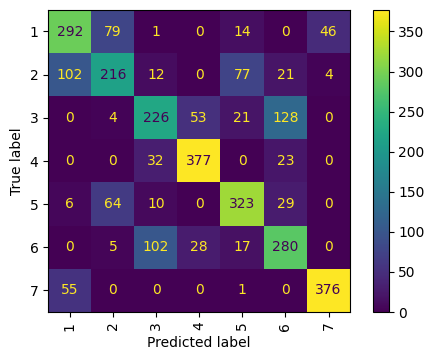

In [114]:
accuracy_LR, precision_LR, recall_LR, y_pred_LR = metric_rep(LR, X_val, y_val);
print(f"******\n accuracy is {accuracy_LR:.2f}\n******")

In [103]:
# RidgeClassifier
RC = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    StandardScaler(),
    RidgeClassifier(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, 
                    max_iter=None, tol=0.001, class_weight=None, solver='auto', 
                    random_state=42)
    )

In [104]:
(RC, y_pred_RC, feat_name_RC) = fit_rep(RC, X_train, y_train, X_val, y_val, kwargs_dict)


 fitting ...
running transformer ....

 getting X_train transformed column labels
running transformer ....
X_train cols: 55 X_fit cols: 46

 predicting ...
running transformer ....
running transformer ....
running transformer ....

 score ...
Training score 0.6384755291005291
Validation score 0.6329365079365079
running transformer ....

 Accuracy ...
Training Accuracy 0.6384755291005291
Validation Accuracy 0.6329365079365079



 predicting y ...
running transformer ....

 plotting confusion matrix ...
running transformer ....

 calculating confusion matrix ...
     0    1    2    3    4    5    6
0  288   74    1    0   28    2   39
1  100  209    3    7   83   26    4
2    0    3  170   79   17  163    0
3    0    0   26  364    0   42    0
4   26   64   42    8  271   21    0
5    0   15   67   50   37  263    0
6   72    4    1    0    6    0  349

 classification report ...
              precision    recall  f1-score   support

           1       0.59      0.67      0.63       432
           2       0.57      0.48      0.52       432
           3       0.55      0.39      0.46       432
           4       0.72      0.84      0.77       432
           5       0.61      0.63      0.62       432
           6       0.51      0.61      0.55       432
           7       0.89      0.81      0.85       432

    accuracy                           0.63      3024
   macro avg       0.63      0.63      0.63      302

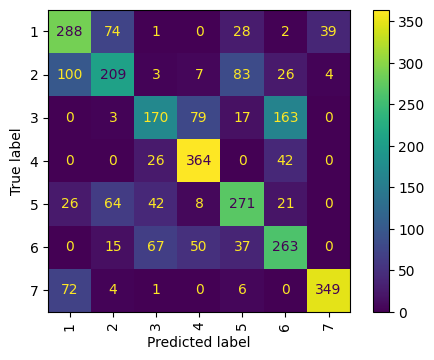

In [105]:
accuracy_RC, precision_RC, recall_RC, y_pred_RC = metric_rep(RC, X_val, y_val)
print(f"******\n accuracy is {accuracy_RC:.2f}\n******")

### Randomforestclassifier and feature_importances_

In [116]:
# RandomForestClassifier
rfc = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=20, 
                           min_samples_split=2, min_samples_leaf=8, min_weight_fraction_leaf=0.0, 
                           max_features=20, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=-1, 
                           random_state=42, verbose=0, warm_start=False, class_weight=None, 
                           ccp_alpha=0.0, max_samples=None)
    )


In [136]:
estimator = [LR, RC, rfc]
est = estimator[2]

In [137]:
(est, y_pred, feat_name) = fit_rep(est, X_train, y_train, X_val, y_val, kwargs_dict)
estimator[2] = est
estimator[2]


 fitting ...
running transformer ....

 getting X_train transformed column labels
running transformer ....
X_train cols: 55 X_fit cols: 46

 predicting ...
running transformer ....
running transformer ....
running transformer ....

 score ...
Training score 0.9107142857142857
Validation score 0.8306878306878307
running transformer ....

 Accuracy ...
Training Accuracy 0.9107142857142857
Validation Accuracy 0.8306878306878307


Pipeline(memory=None,
         steps=[('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function wrangle at 0x7fcc7f0fde18>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args={'cols': ['Id', 'Soil_Type15',
                                                       'Soil_Type7',
                                                       'Soil_Type25',
                                                       'Soil_Type8',
                                                       'Soil_Type28',
                                                       'Soil_Type9',
                                                       'Soil_Type36',
                                                       'Soil_Type27'],
                                              'drop_count': 9},
                                     validate=False)),
                (...
  

In [139]:
estimator

[Pipeline(memory=None,
          steps=[('functiontransformer',
                  FunctionTransformer(accept_sparse=False, check_inverse=True,
                                      func=<function wrangle at 0x7fcc7f0fde18>,
                                      inv_kw_args=None, inverse_func=None,
                                      kw_args={'cols': ['Id', 'Soil_Type15',
                                                        'Soil_Type7',
                                                        'Soil_Type25',
                                                        'Soil_Type8',
                                                        'Soil_Type28',
                                                        'Soil_Type9',
                                                        'Soil_Type36',
                                                        'Soil_Type27'],
                                               'drop_count': 9},
                                      validate=False)),
        

In [ ]:
## tree depth analysis
# max_depth = list()
# for tree in clf.estimators_:
#     max_depth.append(tree.tree_.max_depth)

# print("avg max depth %0.1f" % (sum(max_depth) / len(max_depth)))



In [ ]:
## sklearn permutation_importances
# from sklearn.inspection import permutation_importance
# result = permutation_importance(pipeline, X_val, y_val, 
#                                 n_repeats=5, random_state=0)
# result.keys()
# df = pd.DataFrame({'feature': X_val.columns,
#                    'importances_mean': np.round(result['importances_mean'], 4),
#                    'importances_std': result['importances_std']
#                    })
# df.sort_values(by='importances_mean', ascending=False)

In [ ]:
# # Gradientboosting
# from sklearn.ensemble import GradientBoostingClassifier
# # It needs NaN to be dealth with
# pipeline = make_pipeline(
#     ce.OrdinalEncoder(), 
#     SimpleImputer(strategy='median'), 
#     GradientBoostingClassifier()
# )

# pipeline.fit(X_train, y_train)
# print('Training Accuracy:', pipeline.score(X_train, y_train))
# print('Validation Accuracy:', pipeline.score(X_val, y_val))

In [ ]:
# # XGBoost
# from xgboost import XGBClassifier
# pipeline = make_pipeline(
#     ce.OrdinalEncoder(),
#     XGBClassifier(n_estimators=100, random_state=42, n_jobs=6)
# )

# pipeline.fit(X_train, y_train)

# print('Training Accuracy:', pipeline.score(X_train, y_train))
# print('Validation Accuracy:', pipeline.score(X_val, y_val))

In [ ]:
# # XGBoost early stop fit

# encoder = ce.OrdinalEncoder()
# X_train_encoded = encoder.fit_transform(X_train)
# X_val_encoded = encoder.transform(X_val)
# X_test_encoded = encoder.transform(X_test)

# model = XGBClassifier(
#     n_estimators = 1000,
#     max_depth=8,
#     learning_rate=0.5,
#     num_parallel_tree = 10,
#     n_jobs=-1
# )

# eval_set = [(X_train_encoded, y_train), 
#             (X_val_encoded, y_val)]

# model.fit(X_train_encoded, y_train, 
#           eval_set=eval_set, 
#           eval_metric=['merror', 'mlogloss'], 
#           early_stopping_rounds=50,
#           verbose=True) # Stop if the score hasn't improved in 50 rounds

# print('Training Accuracy:', pipeline.score(X_train_encoded, y_train))
# print('Validation Accuracy:', pipeline.score(X_val_encoded, y_val))

# y_pred = model.predict(X_test_encoded)
# print(y_pred)

# import matplotlib.pyplot as plt
# # retrieve performance metrics
# results = model.evals_result()
# print(results.keys())
# # number of rounds before stop fitting is 148
# n_rounds = len(results['validation_1']["merror"])
# x_axis = range(0, n_rounds)

# # plot classification error
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

# ax1.plot(x_axis, results['validation_0']['merror'], label='Train')
# ax1.plot(x_axis, results['validation_1']['merror'], label='Validation')
# ax1.legend()
# plt.ylabel('Classification MError')
# plt.title('XGBoost Classification MError')

# ax2.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
# ax2.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
# ax2.legend()
# plt.ylabel('Log Loss')
# plt.title('XGBoost Log Loss')

# plt.show()



In [208]:
print(f' X_train shape before pipeline: {X_train.shape}')

# Make pipeline!
pipeline = make_pipeline(
    FunctionTransformer(wrangle, validate=False), 
    # ce.OrdinalEncoder(), 
    # SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=20, 
                           min_samples_split=2, min_samples_leaf=8, min_weight_fraction_leaf=0.0, 
                           max_features=20, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=-1, 
                           random_state=42, verbose=0, warm_start=False, class_weight=None, 
                           ccp_alpha=0.0, max_samples=None)
    )

drop_count = int(0.1*len(Id_skew_cols))
pipeline.set_params(functiontransformer__kw_args={'drop_count': drop_count})

#.fit: WITHOUT CHANGING X APPLIES THE TRANSFORM AND CHECK TO SEE IF y FITS TRANSFORMED OF X
print("\n fitting ...")
pipeline.fit(X_train, y_train)

print("\n getting X_train transformed column labels")
feat_name = pipeline.named_steps['functiontransformer'].transform(X_train).columns

print("X_train: ", len(X_train.columns), "X_fit: ", len(feat_name))
assert len(X_train.columns) == len(feat_name) + drop_count

print("\n predicting ...")
y_pred = pipeline.predict(X_val)

print("\n Accuracy ...")
print('Training Accuracy', accuracy_score(y_train, pipeline.predict(X_train)))
print('Validation Accuracy', accuracy_score(y_val, y_pred))

 X_train shape before pipeline: (12096, 55)

 fitting ...
drop_count parameter:  5
X shape before return: (12096, 50)

 getting X_train transformed column labels
drop_count parameter:  5
X shape before return: (12096, 50)
X_train:  55 X_fit:  50

 predicting ...
drop_count parameter:  5
X shape before return: (3024, 50)

 Accuracy ...
drop_count parameter:  5
X shape before return: (12096, 50)
Training Accuracy 0.9040178571428571
Validation Accuracy 0.8214285714285714


In [209]:
rf = pipeline.named_steps['randomforestclassifier']
print(pipeline.named_steps['randomforestclassifier'].n_features_)
importances = pd.Series(rf.feature_importances_, feat_name).sort_values(ascending=True)

50


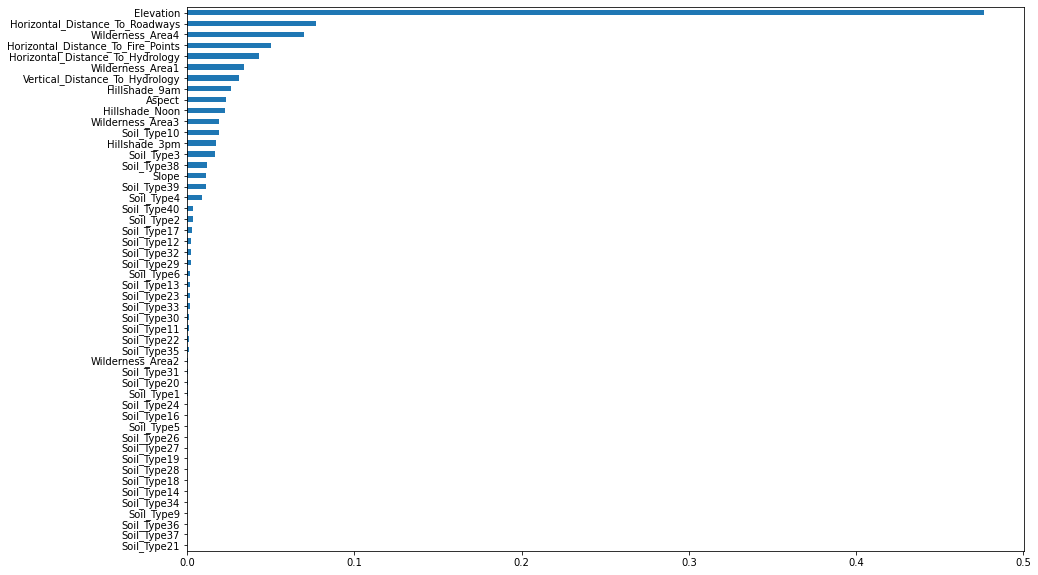

In [210]:
plt.figure(figsize=(15,10))
importances.plot.barh()

In the presence of all the features, feature_importance_ of Id column ranks relatively high. Hence, feature_importance_ by itself cannot be a deciding factor. We drop 10% of skewed columns to get 82% accuracy

### Cross Validation Curve for skewed features

val scores [[0.82231405 0.82596114 0.82389417 0.8222406  0.81893344]
 [0.80867769 0.8147995  0.81438611 0.81603969 0.80942538]
 [0.81528926 0.81438611 0.81397272 0.81025217 0.80611823]
 [0.81280992 0.81934684 0.81686647 0.80694502 0.8147995 ]
 [0.81942149 0.8218272  0.80777181 0.8147995  0.81273253]
 [0.80702479 0.81190575 0.81397272 0.80901199 0.80777181]
 [0.81404959 0.82306738 0.81562629 0.80239768 0.80487805]
 [0.81363636 0.81893344 0.80942538 0.81976023 0.80446465]
 [0.80950413 0.81852005 0.8147995  0.81066556 0.80198429]
 [0.8177686  0.81810666 0.8152129  0.81397272 0.80777181]
 [0.8107438  0.81438611 0.8081852  0.81107896 0.80198429]
 [0.81033058 0.81397272 0.81727987 0.81066556 0.79950393]
 [0.81942149 0.82100041 0.81686647 0.81149235 0.80859859]
 [0.81322314 0.80529144 0.81603969 0.81273253 0.80859859]
 [0.8177686  0.81231914 0.81231914 0.81149235 0.81314593]
 [0.81487603 0.8081852  0.81810666 0.81686647 0.80611823]
 [0.80371901 0.80198429 0.80942538 0.80694502 0.81149235]
 [0

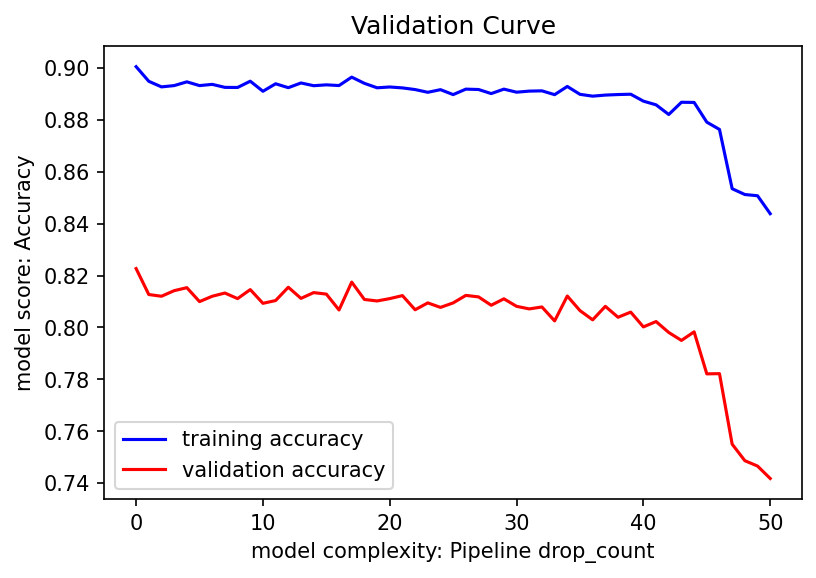

In [211]:
par_name = "drop_count"
param_range = [{par_name: i} for i in range(len(Id_skew_cols))]
param_rangex = [i for i in range(len(Id_skew_cols))]

# par_name = "max_features"
# param_range = np.arange(0.1,1.1,0.1)
# param_rangex = param_range
               
# par_name = "max_depth"
# param_range = range(1,25,1)
# param_rangex = param_range

# par_name = "min_samples_split"
# param_range = np.linspace(10, 0.01*len(X_train), 10, endpoint=True).astype(int)
# param_rangex = param_range

# par_name = "min_samples_leaf"
# param_range = np.linspace(2, 0.001*len(X_train), 10, endpoint=True).astype(int)
# param_rangex = param_range

# par_name = "criterion"
# param_range = ["gini", "entropy"]
# param_rangex = param_range


train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='functiontransformer__kw_args',
    # param_name='randomforestclassifier__'+ par_name, 
    
    param_range=param_range, 
    scoring='accuracy', 
    cv=5,
    n_jobs=-1
)
print("val scores", val_scores)
print("val scores mean", np.mean(val_scores, axis=1))

# Averaging CV scores
plt.figure(dpi=150)
plt.plot(param_rangex, np.mean(train_scores, axis=1), color='blue', label='training accuracy')
plt.plot(param_rangex, np.mean(val_scores, axis=1), color='red', label='validation accuracy')
plt.title('Validation Curve')
plt.xlabel(f'model complexity: Pipeline {par_name}')
plt.ylabel('model score: Accuracy')
plt.legend();

beyoun 30 features drop, validation accuracy starts going down.

### RandomizedSearchCV

In [212]:
# pipe = make_pipeline(FunctionTransformer(log_columns, ), PCA(), SVC())

# param_grid = dict(
#     functiontransformer__kw_args=[
#         {'col_idx': None},
#         {'col_idx': [1]}
#     ],
#     pca__n_components=[2, 5, 10],
#     svc__C=[0.1, 10, 100],
# )
# grid_search = GridSearchCV(pipe, param_grid=param_grid)

# digits = load_digits()
# res = grid_search.fit(digits.data, digits.target)      

In [215]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestclassifier'])

x_n_iter = 1000

param_distributions = {
    # 'simpleimputer__strategy': ['mean', 'median', 'most_frequent'], 
     'functiontransformer__kw_args': [{par_name: i} for i in range(int(0.5*len(Id_skew_cols)))],
    'randomforestclassifier__min_samples_leaf': [random.randint(1, 1000) for i in range(20)], 
    'randomforestclassifier__min_samples_split': [random.randint(2, 1000) for i in range(20)], 
    'randomforestclassifier__max_features': [random.randint(2, 54) for i in range(20)], 
    'randomforestclassifier__criterion': ["gini", "entropy"]
    }

rscv = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=x_n_iter, 
    cv=4, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

rscv.fit(X_train, y_train)

bestpipe = rscv.best_estimator_
print('Cross-validation Accuracy', rscv.best_score_)
print('Best hyperparameters', rscv.best_params_)


Model Hyperparameters:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=20, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Fitting 4 folds for each of 1000 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

drop_count parameter:  19
X shape before return: (12096, 36)
Cross-validation Accuracy 0.8098544973544973
Best hyperparameters {'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__max_features': 20, 'randomforestclassifier__criterion': 'entropy', 'functiontransformer__kw_args': {'drop_count': 19}}


In [218]:
rscv.best_estimator_

Pipeline(memory=None,
         steps=[('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function wrangle at 0x7f684cff1bf8>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args={'drop_count': 19},
                                     validate=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=20, max_features=20,
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=8, min_samples_split=2,
                             

In [216]:
rscv.best_params_

{'functiontransformer__kw_args': {'drop_count': 19},
 'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_features': 20,
 'randomforestclassifier__min_samples_leaf': 8,
 'randomforestclassifier__min_samples_split': 2}

In [219]:
best_feat = bestpipe.named_steps['functiontransformer'].transform(X_train).columns
best_feat, best_feat.shape

drop_count parameter:  19
X shape before return: (12096, 36)


(Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
        'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
        'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
        'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
        'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
        'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type6',
        'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13',
        'Soil_Type14', 'Soil_Type17', 'Soil_Type22', 'Soil_Type23',
        'Soil_Type24', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31',
        'Soil_Type32', 'Soil_Type33', 'Soil_Type38', 'Soil_Type39',
        'Soil_Type40'],
       dtype='object'), (36,))

In [220]:
#.predict: WITHOUT ACTUALLY TRANSFORMING X, APPLIES THE TRANSFORMS TO X AND PREDICT a fitted y
# wrangle_col = pipeline.named_steps['functiontransformer'].transform(X_train).columns


print(f' X_val shape before predict : {X_val.shape}')
print("predicting ...")
y_pred = bestpipe.predict(X_val)
print(f' X_val shape after predict : {X_val.shape}')
print('Validation Accuracy', accuracy_score(y_val, y_pred))

 X_val shape before predict : (3024, 55)
predicting ...
drop_count parameter:  19
X shape before return: (3024, 36)
 X_val shape after predict : (3024, 55)
Validation Accuracy 0.8220899470899471
